In [1]:
# --- 1. Import library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Dunn Index custom function
def dunn_index(X, labels):
    clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []
    for i in clusters:
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:
            intra_cluster = np.max([np.linalg.norm(x - y) for x in cluster_points for y in cluster_points])
            intra_cluster_distances.append(intra_cluster)
    for i in clusters:
        for j in clusters:
            if i < j:
                points_i = X[labels == i]
                points_j = X[labels == j]
                inter_cluster = np.min([np.linalg.norm(x - y) for x in points_i for y in points_j])
                inter_cluster_distances.append(inter_cluster)
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [3]:
# --- 2. Load Data ---
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/clusteringcampaign.csv'
df = pd.read_csv(url, sep='\t')

In [4]:
# --- 3. Preprocessing ---
df = df.drop(columns=['ID'])
df['Education'] = df['Education'].map({
    'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5
})
df['Marital_Status'] = df['Marital_Status'].map({
    'Married': 'Married', 'Together': 'Together', 'Single': 'Single', 'Divorced': 'Divorced',
    'Widow': 'Widow', 'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'
})
df = pd.get_dummies(df, columns=['Marital_Status'])
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Customer_Year'] = df['Dt_Customer'].dt.year
df['Customer_Month'] = df['Dt_Customer'].dt.month
df['Customer_Day'] = df['Dt_Customer'].dt.day
df = df.drop(columns=['Dt_Customer', 'Z_CostContact', 'Z_Revenue'])
df['Income'] = SimpleImputer(strategy='median').fit_transform(df[['Income']])

In [5]:
# --- 4. Scaling ---
scaler = StandardScaler()
X = scaler.fit_transform(df)

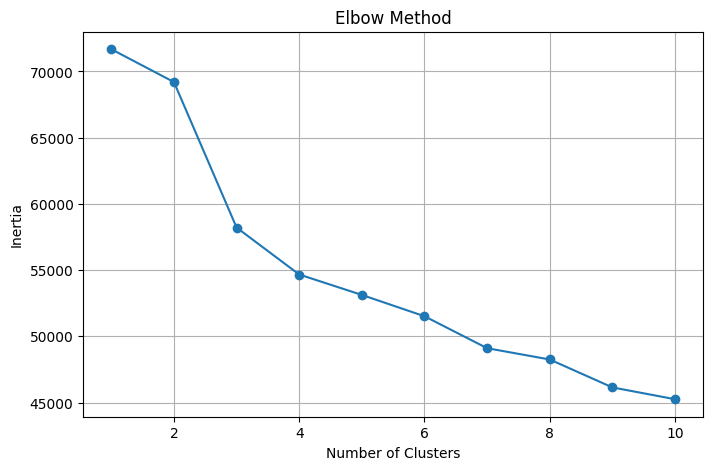

In [7]:
# --- 5. Elbow Method ---
k_range = range(1, 11)
inertia = []
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

In [8]:
# --- 6. Cluster Evaluation Metrics ---
silhouette_scores = []
calinski_scores = []
davies_scores = []
dunn_scores = []

for k in k_range:
    if k > 1:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_scores.append(davies_bouldin_score(X, labels))
        dunn_scores.append(dunn_index(X, labels))
    else:
        silhouette_scores.append(0)
        calinski_scores.append(0)
        davies_scores.append(np.inf)
        dunn_scores.append(0)

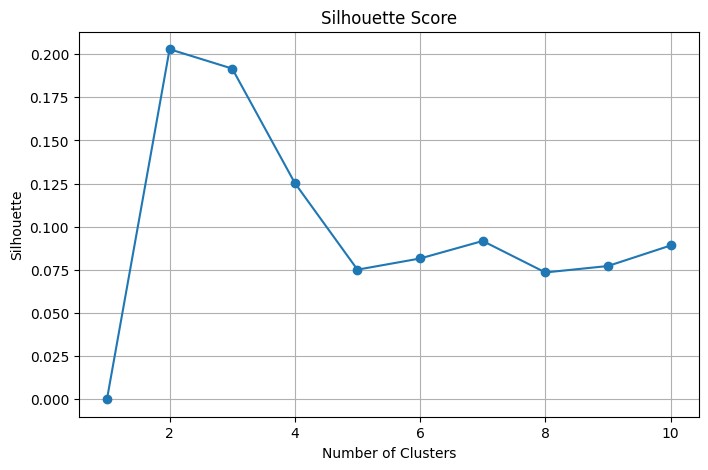

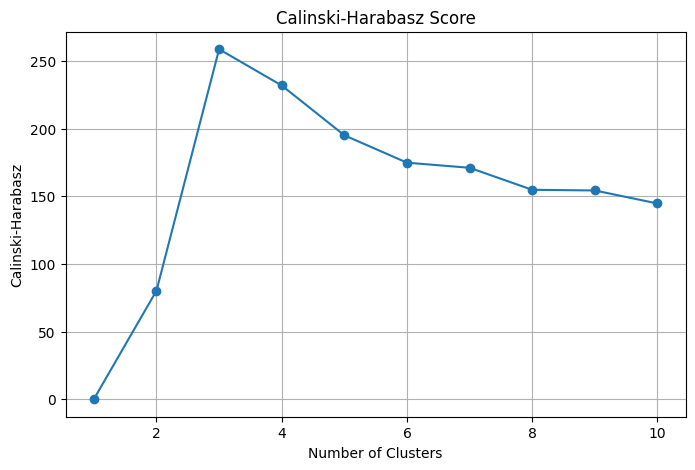

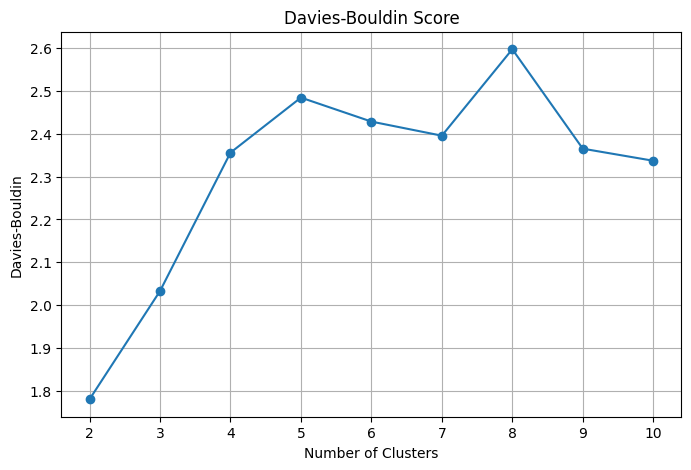

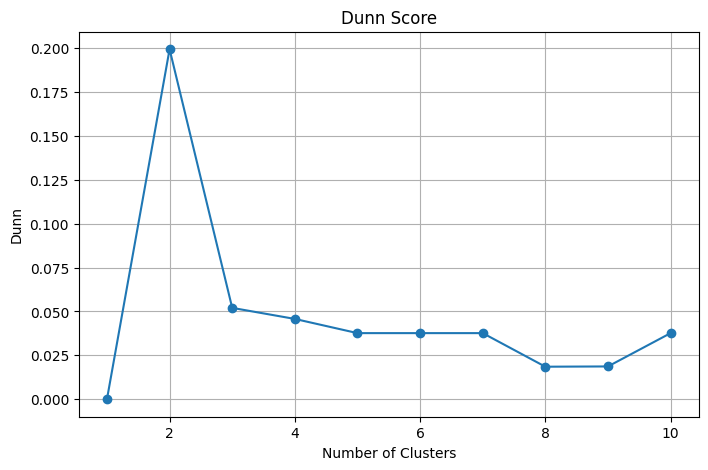

In [9]:
# Plot
metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Dunn']
values = [silhouette_scores, calinski_scores, davies_scores, dunn_scores]

for metric, val in zip(metrics, values):
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, val, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.title(f'{metric} Score')
    plt.grid()
    plt.show()

In [10]:
# --- 7. Final Clustering Models ---
# KMeans
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_labels = agglo.fit_predict(X)

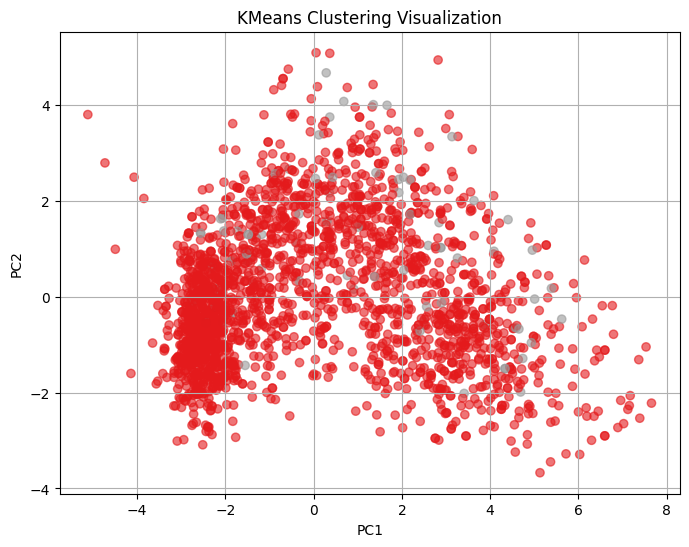

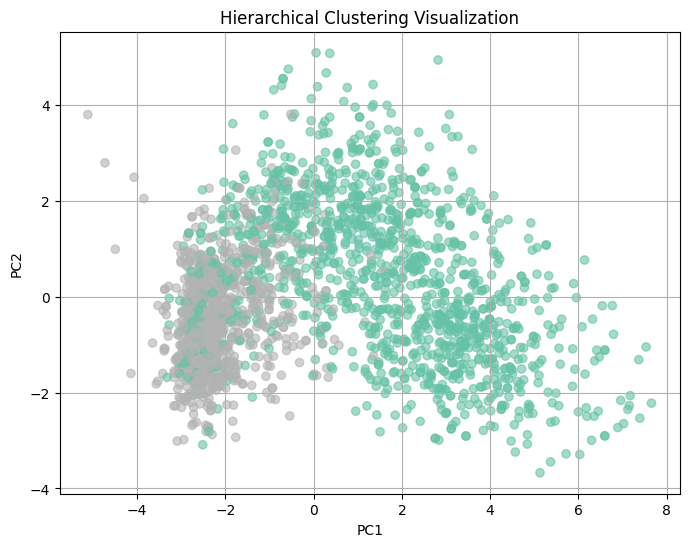

In [11]:
# --- 8. PCA Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot KMeans
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Set1', alpha=0.6)
plt.title('KMeans Clustering Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

# Plot Agglomerative
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='Set2', alpha=0.6)
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

## Penjelasan Matematis Evaluasi Clustering

### 1. **Inertia (Within-Cluster Sum of Squares - WCSS)**  
Digunakan pada **Elbow Method** untuk mencari jumlah cluster optimal.

**Formula:**

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{x_j \in C_i} \| x_j - \mu_i \|^2
$$

**Penjelasan:**
- $( k )$: jumlah cluster
- $( C_i )$: himpunan data pada cluster ke-i
- $( \mu_i )$: centroid dari cluster $( C_i )$
- $( \| x_j - \mu_i \|^2 )$: jarak kuadrat antara titik data $( x_j )$ dan centroid-nya

Semakin kecil nilai inertia, semakin padat cluster-nya, namun terlalu kecil bisa berarti overfitting.

---

### 2. **Silhouette Coefficient**

**Formula:**

$$
s = \frac{b - a}{\max(a, b)}
$$

**Penjelasan:**
- $( a )$: rata-rata jarak antar data dalam **cluster yang sama**
- $( b )$: rata-rata jarak antar data dengan **cluster terdekat yang berbeda**
- Nilai $( s \in [-1, 1] )$
  - Nilai mendekati **1** → pemisahan cluster baik
  - Nilai mendekati **0** → tumpang tindih antar cluster
  - Nilai negatif → data lebih dekat ke cluster lain (salah klaster)

---

### 3. **Calinski-Harabasz Index (Variance Ratio Criterion)**

**Formula:**

$$
\text{CH} = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

**Penjelasan:**
- $( \text{Tr}(B_k) )$: between-cluster dispersion (variasi antar cluster)
- $( \text{Tr}(W_k) )$: within-cluster dispersion (variasi dalam cluster)
- $( n )$: jumlah total data
- $( k )$: jumlah cluster
- Nilai **lebih tinggi lebih baik**

---

### 4. **Davies-Bouldin Index**

**Formula:**

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{s_i + s_j}{d_{ij}} \right)
$$

**Penjelasan:**
- $( s_i )$: rata-rata jarak antara tiap titik di cluster $( i )$ ke centroid
$( i )$
- $( d_{ij} )$: jarak antara centroid $( i )$ dan $( j )$
- Nilai **lebih kecil lebih baik** → cluster saling berjauhan dan kompak

---

### 5. **Dunn Index**

**Formula:**

$$
\text{Dunn} = \frac{\min\limits_{i \ne j} d(C_i, C_j)}{\max\limits_{1 \le k \le K} \delta(C_k)}
$$

**Penjelasan:**
- $( d(C_i, C_j) )$: jarak minimum antar titik dari dua cluster berbeda (inter-cluster distance)
- $( \delta(C_k) )$: jarak maksimum antar titik dalam satu cluster (intra-cluster distance)
- Nilai **lebih tinggi lebih baik**, menunjukkan cluster yang saling terpisah dan rapat
